In [13]:
import torch
import csv
import numpy as np
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.nn as nn
from torch_geometric.nn import GATConv
import torch.nn.functional as F
from sklearn import metrics


DATA_PATH = '/home/skrhakv/deeplife/deeplife-project/data'
ESM_EMBEDDINGS_PATH = '/home/skrhakv/esm2/embeddings-3B-deeplife'
ADJACENCY_MATRICES_PATH = f'{DATA_PATH}/apo-distance-matrices' 
PROCESSED_GRAPHS_PATH = f'{DATA_PATH}/processed_graphs'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [124]:
DISTANCE_THRESHOLD = 3
BATCH_SIZE = 32

def process_sequence_dataset(annotation_path, embeddings_paths):
    Xs = {}
    Ys = {}
    with open(annotation_path) as f:
        reader = csv.reader(f, delimiter=";")
        for row in reader:
            id = row[0].lower() + row[1]
            sequence = row[4]

            if row[3] == '':
                continue
            
            # load the precomputed embedding
            if id not in Xs:
                for embeddings_path in embeddings_paths:
                    filename = id + '.npy'
                    embedding = np.load(f'{embeddings_path}/{filename}')
                    if id not in Xs:
                        Xs[id] = embedding
                    else:
                        Xs[id] = np.concatenate((Xs[id],embedding), axis = 1)
                    

            # load the annotations denoting whether particular residue is binding or not
            # we use binary annotation: 0=non-binding; 1=binding
            if id not in Ys:
                Ys[id] = np.zeros(embedding.shape[0])
            for (aa, residue_idx) in [(residue[0], int(residue[1:])) for residue in row[3].split(' ')]:
                assert sequence[residue_idx] == aa
                Ys[id][residue_idx] = 1

    return Xs, Ys


def get_adjacency_info(id):
    distance_matrix = np.load(f'{ADJACENCY_MATRICES_PATH}/{id}.npy')

    edge_indices = []

    for iy, ix in np.ndindex(distance_matrix.shape):
        if iy >= ix:
            continue

        if distance_matrix[iy, ix] <= DISTANCE_THRESHOLD:
            edge_indices += [[iy, ix], [ix, iy]]
    
    edge_indices = torch.tensor(edge_indices)
    edge_indices = edge_indices.t().to(torch.long).view(2, -1)
    return edge_indices


def load_dataset(dataset_annotation_filepath):
    Xs_train, Ys_train = process_sequence_dataset(dataset_annotation_filepath, [ESM_EMBEDDINGS_PATH])

    protein_list = []
    for key in Xs_train.keys():
        protein_features = torch.tensor(Xs_train[key], dtype=torch.float32)
        protein_labels = torch.tensor(Ys_train[key], dtype=torch.int64)
        protein_edges = get_adjacency_info(key)
        protein = Data(x=protein_features, edge_index=protein_edges, y=protein_labels)
        protein_list.append(protein)
        if protein_edges.shape[1] > 0:
            if protein_edges.max() >= protein_features.size(0):
                print(f'{key}: {protein_edges.max()}, {protein_features.size(0)}')
        
    return protein_list


In [125]:
test_proteins = load_dataset(f'{DATA_PATH}/apo_test.txt')
train_proteins = load_dataset(f'{DATA_PATH}/apo_train.txt')

# COPIED:

In [ ]:
from torch.utils.data import Dataset

class SequenceCryptoBenchDataset(Dataset):
    def __init__(self, _Xs, _Ys):
        _Xs_list = []
        _Ys_list = []
        for key, _ in _Xs.items():
            print(f'Processing {key} ...')
            _Xs_list.append(_Xs[key])
            _Ys_list.append(_Ys[key])

        print('Concatenating ...')
        Xs_list = np.concatenate(_Xs_list, axis=0)
        Ys_list = np.concatenate(_Ys_list, axis=0)

        print('Converting to torch tensor ...')
        self.Xs = torch.tensor(Xs_list, dtype=torch.float32)
        self.Ys = torch.tensor(Ys_list, dtype=torch.int64)

    def __len__(self):
        assert len(self.Xs) == len(self.Ys)
        return len(self.Xs)

    def __getitem__(self, idx):
        x = self.Xs[idx]
        y = self.Ys[idx]
        return x, y
    
Xs_train_apo, Ys_train_apo = process_sequence_dataset(f'{DATA_PATH}/apo_train.txt', [ESM_EMBEDDINGS_PATH])
train_dataset_apo = SequenceCryptoBenchDataset(Xs_train_apo, Ys_train_apo)

Xs_test_apo, Ys_test_apo = process_sequence_dataset(f'{DATA_PATH}/apo_test.txt', [ESM_EMBEDDINGS_PATH])
test_dataset_apo = SequenceCryptoBenchDataset(Xs_test_apo, Ys_test_apo)

In [51]:

DROPOUT = 0.3
EMBEDDING_DIM = 2560
HEADS = 16
HIDDEN_CHANNELS = 8
LAYER_WIDTH = 100
class GCN(nn.Module):
    def __init__(self, input_dim=EMBEDDING_DIM):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=input_dim, out_features=LAYER_WIDTH)
        self.dropout1 = nn.Dropout(DROPOUT)

        self.layer_2 = nn.Linear(in_features=LAYER_WIDTH, out_features=LAYER_WIDTH)
        self.dropout2 = nn.Dropout(DROPOUT)

        self.layer_3 = nn.Linear(in_features=LAYER_WIDTH, out_features=1)

        self.relu = nn.ReLU()

    def forward(self, x, _):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.dropout2(self.relu(self.layer_2(self.dropout1(self.relu(self.layer_1(x)))))))


In [57]:

class_weights = torch.tensor([ 0.5235, 11.1424], device='cuda:0')
model = GCN().to(device)
optimizer = torch.optim.Adam(params=model.parameters(),
                            lr=0.0001)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])


def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

def train(model, optimizer, epochs, batch_size, loss_fn, train_dataset, test_dataset):
    model = model.to(device)

    # Create an optimizer
    _, y_train = train_dataset[:]
    X_test, y_test, = test_dataset[:]

    # compute class weights (because the dataset is heavily imbalanced)
    print(f'Class weights: ', class_weights)
    # BCEWithLogitsLoss - sigmoid is already built-in!
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])

    X_test, y_test = X_test.to(device), y_test.to(device).float()

    train_losses, test_losses = [], []

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        #
        # TEST
        #
        model.eval()
        with torch.inference_mode():

            test_logits = model(X_test).squeeze()
            test_pred = torch.round(torch.sigmoid(test_logits))

            test_loss = loss_fn(test_logits,
                                y_test)
            test_losses.append(test_loss.cpu().detach().numpy())

            # compute metrics on test dataset
            test_acc = accuracy_fn(y_true=y_test,
                                   y_pred=test_pred)
            fpr, tpr, thresholds = metrics.roc_curve(y_test.cpu().numpy(), torch.sigmoid(test_logits).cpu().numpy())
            roc_auc = metrics.auc(fpr, tpr)

            mcc = metrics.matthews_corrcoef(y_test.cpu().numpy(), test_pred.cpu().numpy())

        #
        # TRAIN
        #
        batch_losses = []
        for id_batch, (x_batch, y_batch) in enumerate(train_dataloader):

            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device).float()

            model.train()

            y_logits = model(x_batch).squeeze()
            y_pred = torch.round(torch.sigmoid(y_logits))

            loss = loss_fn(y_logits,
                           y_batch)
            acc = accuracy_fn(y_true=y_batch,
                              y_pred=y_pred)

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            batch_losses.append(loss.cpu().detach().numpy())

        train_losses.append(sum(batch_losses) / len(batch_losses))
        #if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {test_acc:.2f}% | Test loss: {test_loss:.5f}, AUC: {roc_auc}, MCC: {mcc}, sum: {sum(test_pred)}")

fpr_3, tpr_3, roc_auc_3 = train(model, optimizer, epochs=10, batch_size=16384, loss_fn=loss_fn, 
      train_dataset=train_dataset_apo, test_dataset=test_dataset_apo)

Class weights:  tensor([ 0.5235, 11.1424], device='cuda:0')
Epoch: 0 | Loss: 1.00346, Accuracy: 65.87% | Test loss: 1.35119, AUC: 0.4447730893372259, MCC: -0.03196521490097587, sum: 27036.0
Epoch: 1 | Loss: 0.86132, Accuracy: 84.13% | Test loss: 0.86205, AUC: 0.7669108046710278, MCC: 0.2197528791782621, sum: 13585.0
Epoch: 2 | Loss: 0.74930, Accuracy: 85.52% | Test loss: 0.80664, AUC: 0.8041328652705416, MCC: 0.264461713239608, sum: 12868.0
Epoch: 3 | Loss: 0.72686, Accuracy: 86.03% | Test loss: 0.78153, AUC: 0.8192789900766497, MCC: 0.28368596067536894, sum: 12640.0
Epoch: 4 | Loss: 0.71378, Accuracy: 86.15% | Test loss: 0.76642, AUC: 0.8275608194125883, MCC: 0.2959321988473, sum: 12725.0
Epoch: 5 | Loss: 0.70132, Accuracy: 86.39% | Test loss: 0.75732, AUC: 0.8326808042464886, MCC: 0.3044672641346015, sum: 12605.0
Epoch: 6 | Loss: 0.62709, Accuracy: 87.04% | Test loss: 0.75358, AUC: 0.8362217008031798, MCC: 0.3100605668018263, sum: 11969.0
Epoch: 7 | Loss: 0.61261, Accuracy: 86.88% | 

TypeError: cannot unpack non-iterable NoneType object

# : END OF COPYING

In [129]:

DROPOUT = 0.6
EMBEDDING_DIM = 2560
HEADS = 16
HIDDEN_CHANNELS = 100
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234567)
        self.dropout0 = nn.Dropout(DROPOUT)

        self.conv1 = GATConv(EMBEDDING_DIM, HIDDEN_CHANNELS, heads=HEADS, dropout=DROPOUT, concat=False)
        # self.dropout00 = nn.Dropout(DROPOUT)

        # self.conv2 = GATConv(HIDDEN_CHANNELS * HEADS, HIDDEN_CHANNELS, heads=HEADS,
        #                     concat=False, dropout=DROPOUT)

        self.linear1 = nn.Linear(HIDDEN_CHANNELS, HIDDEN_CHANNELS * HEADS)
        self.dropout1 = nn.Dropout(DROPOUT)
        
        self.linear2 = nn.Linear(in_features=HIDDEN_CHANNELS * HEADS, out_features=HIDDEN_CHANNELS * HEADS)
        self.dropout2 = nn.Dropout(DROPOUT)

        self.linear3 = nn.Linear(in_features=HIDDEN_CHANNELS * HEADS, out_features=1)
        self.dropout3 = nn.Dropout(DROPOUT)

        self.relu = nn.ReLU()

    def forward(self, x, edge_index):
        x = self.dropout0(x)
    
        x = self.conv1(x, edge_index)
        # x = self.relu(x)
        # x = self.dropout00(x)

        # x = self.conv2(x, edge_index)

        x = self.relu(x)
        x = self.dropout1(x)
        x = self.linear1(x)

        x = x.relu()
        x = self.dropout2(x)
        x = self.linear2(x)

        x = x.relu()
        x = self.dropout3(x)
        x = self.linear3(x)

        return x

In [131]:
BATCH_SIZE = 8

train_loader = DataLoader(train_proteins, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_proteins, batch_size=len(test_proteins))


class_weights = torch.tensor([ 0.5235, 11.1424], device='cuda:0')
model = GCN().to(device)
optimizer = torch.optim.Adam(params=model.parameters(),
                            lr=0.0001)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])


def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

def train(model, optimizer, epochs, loss_fn, train_dataloader, test_dataloader):
    model = model.to(device)

    # compute class weights (because the dataset is heavily imbalanced)
    print(f'Class weights: ', class_weights)
    # BCEWithLogitsLoss - sigmoid is already built-in!
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])

    train_losses, test_losses = [], []

    for epoch in range(epochs):
        #
        # TEST
        #
        model.eval()
        with torch.inference_mode():
            for batch_id, data in enumerate(test_dataloader):   
                X_test = data.x.to(device)
                y_test = data.y.to(device).float()
                edges = data.edge_index.to(device)

                test_logits = model(X_test, edges).squeeze()
                test_pred = torch.round(torch.sigmoid(test_logits))

                test_loss = loss_fn(test_logits,
                                    y_test)
                test_losses.append(test_loss.cpu().detach().numpy())

                # compute metrics on test dataset
                test_acc = accuracy_fn(y_true=y_test,
                                       y_pred=test_pred)
                fpr, tpr, thresholds = metrics.roc_curve(y_test.cpu().numpy(), torch.sigmoid(test_logits).cpu().numpy())
                roc_auc = metrics.auc(fpr, tpr)

                mcc = metrics.matthews_corrcoef(y_test.cpu().numpy(), test_pred.cpu().numpy())

        #
        # TRAIN
        #
        batch_losses = []
        for id_batch, data in enumerate(train_dataloader):
            x_batch = data.x.to(device)
            y_batch = data.y.to(device).float()
            edges = data.edge_index.to(device)
            model.train()

            y_logits = model(x_batch, edges).squeeze()
            y_pred = torch.round(torch.sigmoid(y_logits))

            loss = loss_fn(y_logits,
                           y_batch)
            acc = accuracy_fn(y_true=y_batch,
                              y_pred=y_pred)

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            batch_losses.append(loss.cpu().detach().numpy())

        train_losses.append(sum(batch_losses) / len(batch_losses))
        #if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {test_acc:.2f}% | Test loss: {test_loss:.5f}, AUC: {roc_auc}, MCC: {mcc}, sum: {sum(test_pred)}")
    return train_losses, test_losses
train_losses, test_losses = train(model, optimizer, 200, loss_fn, train_loader, test_loader)

# before
# Epoch: 9 | Loss: 0.56604, Accuracy: 88.67% | Test loss: 0.76909, AUC: 0.8404747014689036, MCC: 0.3271917471805186, sum: 10366.0

# between
# Epoch: 9 | Loss: 0.55879, Accuracy: 88.88% | Test loss: 0.76789, AUC: 0.8405509543368965, MCC: 0.3288717653870401, sum: 10141.0

# GAT
# Epoch: 99 | Loss: 0.49741, Accuracy: 83.00% | Test loss: 0.77240, AUC: 0.8372716739098521, MCC: 0.29271584249931554, sum: 16152.0


Class weights:  tensor([ 0.5235, 11.1424], device='cuda:0')
Epoch: 0 | Loss: 1.63773, Accuracy: 93.73% | Test loss: 1.05802, AUC: 0.4542079866858349, MCC: -0.005317408755528438, sum: 865.0
Epoch: 1 | Loss: 1.26348, Accuracy: 57.80% | Test loss: 1.05842, AUC: 0.5976158466350403, MCC: 0.06572505291665946, sum: 36845.0
Epoch: 2 | Loss: 1.16847, Accuracy: 90.74% | Test loss: 1.05423, AUC: 0.6185243800925465, MCC: 0.052410215350449034, sum: 4251.0
Epoch: 3 | Loss: 1.04990, Accuracy: 58.03% | Test loss: 1.06537, AUC: 0.6281244931044366, MCC: 0.08934022370392815, sum: 37132.0
Epoch: 4 | Loss: 1.07636, Accuracy: 39.72% | Test loss: 1.06742, AUC: 0.6496076141053844, MCC: 0.08486675426222876, sum: 54598.0
Epoch: 5 | Loss: 0.93725, Accuracy: 30.24% | Test loss: 1.06816, AUC: 0.6427092223904711, MCC: 0.07804728219976384, sum: 63433.0
Epoch: 6 | Loss: 0.88445, Accuracy: 26.87% | Test loss: 1.06816, AUC: 0.6388991126735202, MCC: 0.07945305893695291, sum: 66616.0
Epoch: 7 | Loss: 0.88470, Accuracy: 2

([1.9780298007859125,
  1.4441742499669392,
  1.198435644308726,
  1.0958315995004442,
  1.0394750403033362,
  0.999583770831426,
  0.9780301915274726,
  0.9571505486965179,
  0.9437823659843869,
  0.9233224822415246,
  0.9110089706050025,
  0.8997445603211721,
  0.8815844423241086,
  0.8744452893733978,
  0.861532555686103,
  0.8513534896903567,
  0.8420613474316068,
  0.8328515589237213,
  0.8270929323302375,
  0.8227197064293755,
  0.8170174625184801,
  0.8085716896586947,
  0.8053434954749213,
  0.7974164187908173,
  0.7935640149646335,
  0.7899925841225518,
  0.7853214177820418,
  0.7804101142618391,
  0.7770180172390408,
  0.7783757348855337,
  0.7736527389950223,
  0.773956322007709,
  0.7680418988068899,
  0.7654115226533678,
  0.758845653798845,
  0.7572651207447052,
  0.7567404574818082,
  0.7549782594045004,
  0.7501677374045054,
  0.7509016295274099,
  0.7513318889670901,
  0.7470822268062167,
  0.7475545638137393,
  0.7442335718207889,
  0.7445328964127435,
  0.74189925856

In [ ]:

DROPOUT = 0.3
EMBEDDING_DIM = 2560
HEADS = 16
HIDDEN_CHANNELS = 8
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234567)
        # self.conv1 = GATConv(EMBEDDING_DIM, HIDDEN_CHANNELS, heads=HEADS, dropout=DROPOUT)
        self.linear1 = nn.Linear(EMBEDDING_DIM, HIDDEN_CHANNELS * HEADS)
        # self.conv2 = GATConv(HIDDEN_CHANNELS * HEADS, 1, heads=1, dropout=DROPOUT)
        self.dropout1 = nn.Dropout(DROPOUT)

        self.linear2 = nn.Linear(in_features=HIDDEN_CHANNELS * HEADS, out_features=HIDDEN_CHANNELS * HEADS)
        self.dropout2 = nn.Dropout(DROPOUT)

        self.linear3 = nn.Linear(in_features=HIDDEN_CHANNELS * HEADS, out_features=1)
        self.dropout3 = nn.Dropout(DROPOUT)

        self.relu = nn.ReLU()

    def forward(self, x, edge_index):
        # x = F.dropout(x, p=DROPOUT, training=self.training)
        
        # x = self.conv1(x, edge_index)

        x = self.relu(x)
        x = self.dropout1(x)
        x = self.linear1(x)

        x = x.relu()
        x = self.dropout2(x)
        x = self.linear2(x)

        x = x.relu()
        x = self.dropout3(x)
        x = self.linear3(x)

        return x

In [67]:
BATCH_SIZE = 12
train_loader = DataLoader(train_proteins, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_proteins, batch_size=len(test_proteins), shuffle=True)

model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
class_weights = torch.tensor([ 0.5235, 11.1424], device='cuda:0')
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights[1])

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

def train(train_loader, test_loader):
    batch_losses = []
    for batch_id, data in enumerate(train_loader):  
        model.train()
        optimizer.zero_grad()  
        out = model(data.x.to(device), data.edge_index.to(device)).squeeze()

        loss = criterion(out, data.y.float().to(device))  # Compute the loss solely based on the training nodes.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        batch_losses.append(loss.cpu().detach().numpy())

    for batch_id, data in enumerate(test_loader):  
        model.eval()
        test_logits = model(data.x.to(device), data.edge_index.to(device)).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits)).cpu()

        test_loss = criterion(test_logits, data.y.float().to(device))
        
        test_acc = accuracy_fn(y_true=data.y,
                                y_pred=test_pred)
        fpr, tpr, thresholds = metrics.roc_curve(data.y.numpy(), torch.sigmoid(test_pred).detach().numpy())
        roc_auc = metrics.auc(fpr, tpr)

        mcc = metrics.matthews_corrcoef(data.y.numpy(), test_pred.detach().numpy())
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {test_acc:.2f}% | Test loss: {test_loss:.5f}, AUC: {roc_auc}, MCC: {mcc}, sum: {sum(test_pred)}")
    return loss.cpu().detach().numpy(), test_loss.cpu().detach().numpy()

test_losses = []
train_losses = []
for epoch in range(1, 30):
    loss, test_loss = train(train_loader, test_loader)
    test_losses.append(loss)
    train_losses.append(test_loss)

    # TODO: GCN to GAT, maybe add Linear layer?

Epoch: 1 | Loss: 0.82122, Accuracy: 87.68% | Test loss: 0.81590, AUC: 0.7007573512359389, MCC: 0.27451946167671926, sum: 10611.0
Epoch: 2 | Loss: 0.62505, Accuracy: 87.71% | Test loss: 0.77452, AUC: 0.726788032263894, MCC: 0.30430126299541016, sum: 11091.0
Epoch: 3 | Loss: 0.51202, Accuracy: 88.19% | Test loss: 0.75662, AUC: 0.7354786214858118, MCC: 0.31956952555210544, sum: 10800.0
Epoch: 4 | Loss: 0.66332, Accuracy: 87.59% | Test loss: 0.74778, AUC: 0.7467993300246597, MCC: 0.3249600637796976, sum: 11596.0
Epoch: 5 | Loss: 0.68349, Accuracy: 87.87% | Test loss: 0.74795, AUC: 0.7462397490606378, MCC: 0.3276300546174695, sum: 11313.0
Epoch: 6 | Loss: 0.54107, Accuracy: 87.57% | Test loss: 0.74550, AUC: 0.7519145541598419, MCC: 0.3302353309775568, sum: 11718.0
Epoch: 7 | Loss: 0.51086, Accuracy: 87.84% | Test loss: 0.75372, AUC: 0.7483210100336968, MCC: 0.3294996979953315, sum: 11386.0
Epoch: 8 | Loss: 0.63426, Accuracy: 87.67% | Test loss: 0.76050, AUC: 0.7516218334594135, MCC: 0.33106

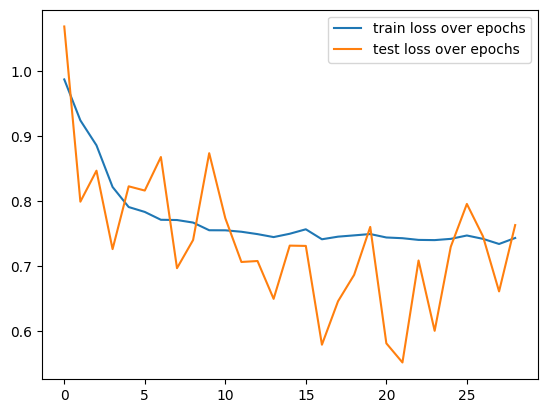

In [35]:
import matplotlib.pyplot as plt

plt.plot(train_losses,label="train loss over epochs")
plt.plot(test_losses,label="test loss over epochs")
plt.legend()
plt.show()

In [7]:
for batch_id, data in enumerate(test_loader): 
    print(batch_id)
    assert data.edge_index.max() < data.x.size(0), f'{data.edge_index.max()}, {data.x.size(0)}'

0
